In [2]:
import librosa
import librosa.display
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
y, sr = librosa.load('../recordings/pizzatacowes.m4a')
print('Sample rate: ', sr)

c:\users\wesle\appdata\local\programs\python\python38\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Sample rate:  22050


In [4]:
# create low pass Butterworth filter:
cutoff = 10e3
sos = sig.butter(10, cutoff, fs=sr, btype='lowpass', analog=False, output='sos')
filtered = sig.sosfilt(sos, y)

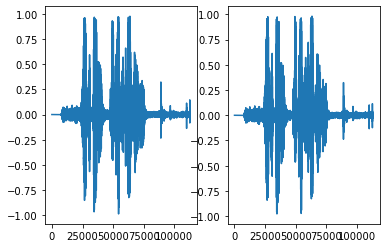

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(y)
axes[1].plot(filtered)
plt.show()

In [15]:
# Downsample
nsr = 11025
resampled = librosa.resample(filtered, sr, nsr)

# Create STFT
n_ftt = 512
spec1 = librosa.stft(resampled, n_fft=n_ftt, window=sig.windows.hamming)
spec1 = np.abs(spec1)

# Denoise
spec2 = librosa.decompose.nn_filter(spec1)

Text(0.5, 1.0, 'Power spectrogram')

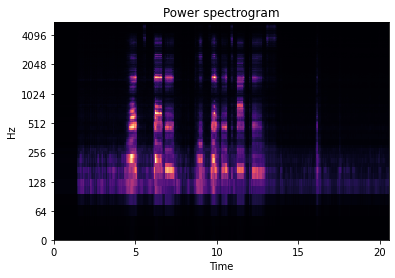

In [16]:
fig, ax = plt.subplots()
librosa.display.specshow(spec2, sr=nsr, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')

Text(0.5, 1.0, 'Filtered')

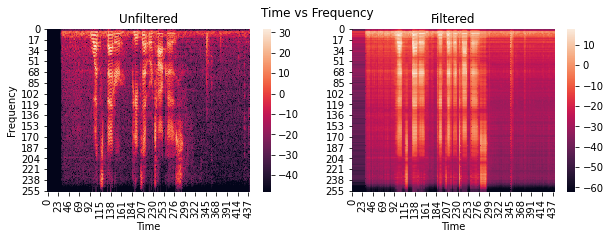

In [17]:
# plot filtered and unfiltered side by side
fig, axes = plt.subplots(1, 2, figsize=(10,3), sharey=False)
sns.heatmap(librosa.amplitude_to_db(spec1), ax=axes[0])
sns.heatmap(librosa.amplitude_to_db(spec2), ax=axes[1])
fig.suptitle('Time vs Frequency')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Unfiltered')
axes[1].set_xlabel('Time')
axes[1].set_title('Filtered')

In [18]:
spec2.shape

(257, 442)

In [19]:
def _log_bin(arr, n_bins):
    bands = np.array([10*2**i for i in range(n_bins - 1)])
    idxs = np.arange(len(arr))
    split_arr = np.split(arr, np.searchsorted(idxs, bands))
    return split_arr 

In [20]:
def ft_filter(ft, n_bins, alpha=1):
    binned_ft = _log_bin(ft, n_bins)
    for i, band in enumerate(binned_ft):
        band_max = np.max(band)
        filtered = np.where(band < band_max, 0, band)
        binned_ft[i] = filtered
    joined_filtered = np.concatenate(binned_ft)
    thresh = np.mean(joined_filtered)
    
    return np.where(joined_filtered < thresh * alpha, 0, joined_filtered)

In [21]:
def spec_filter(spec, n_bins):
    filtered = np.zeros_like(spec.T)
    for i, dft in enumerate(spec.T):
        filtered[i] = ft_filter(dft, n_bins)
    return filtered.T

Text(0.5, 1.0, 'Power spectrogram')

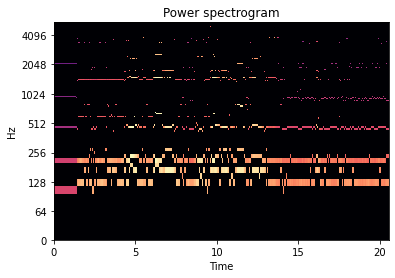

In [22]:
spec3 = spec_filter(spec2, 6)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(spec3), sr=nsr, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')

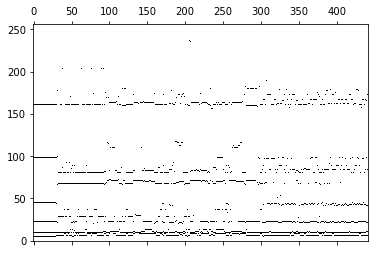

In [27]:
# Sparse matrix representation
plt.spy(spec3, origin='lower', aspect='auto')